In [23]:
# load libraries
library(tidyverse)
library(ggplot2)

# import and clean
salary_data <- read.csv("Dataset salary 2024.csv")
names(salary_data) <- gsub("_", ".", names(salary_data))
salary_data <- na.omit(salary_data)

# pre-processing (convert ordinal/categorical variables to factors)
pre_processed_data <- salary_data %>%
  # higher experience = higher numerical value
  mutate(experience.level = factor(experience.level,
                                  levels = c("EN", "MI", "SE", "EX"),
                                  ordered = TRUE)) %>%
  # order by inc size
  mutate(company.size = factor(company.size,
                               levels = c("S", "M", "L"),
                               ordered = TRUE)) %>%
  # treat as ordered factor
  mutate(remote.ratio = factor(remote.ratio,
                               levels = c(0, 50, 100),
                               labels = c("On-site", "Hybrid", "Remote"),
                               ordered = TRUE))

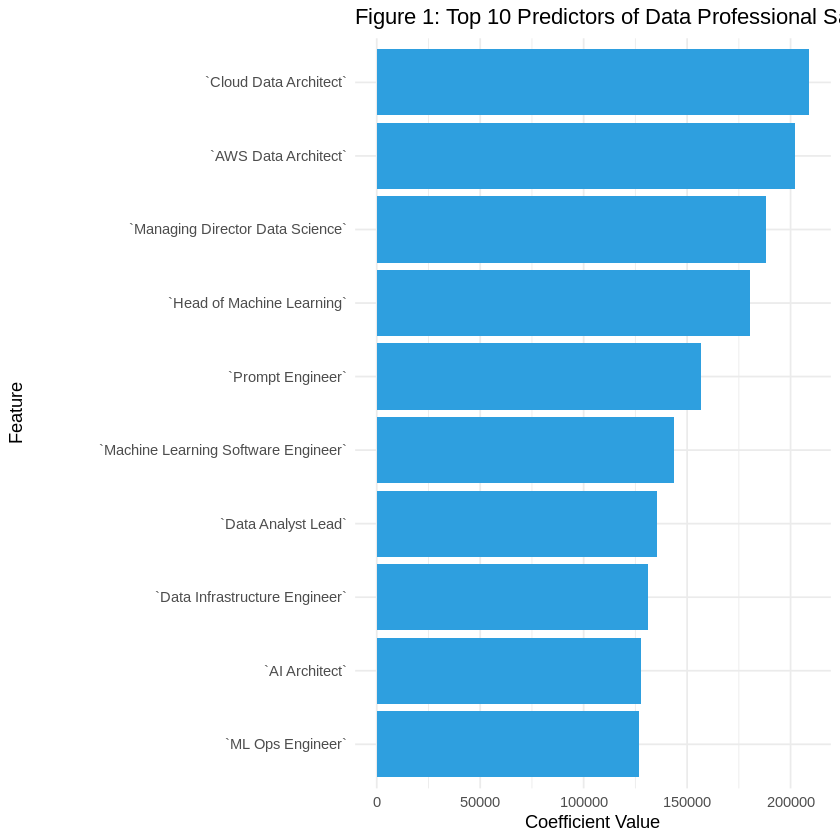

In [33]:
# multiple linear regression
set.seed(42)

# model matrix with 'dummy variables' (turn Job Title and others into 0s/1s)
# predict salary in USD (use Experience, Job Title, Company Size, Work Year, and Remote Ratio)
data_matrix <- model.matrix(salary.in.usd ~ experience.level + job.title + company.size + work.year + remote.ratio,
                            data = pre_processed_data)

# convert the 0s and 1s back to data frame...keep 'salary.in.usd' column
data_final <- as.data.frame(data_matrix[, -1])
data_final$Salary <- pre_processed_data$salary.in.usd

# training (70%) and testing (30%)
sample_indices <- sample(seq_len(nrow(data_final)), size = floor(0.70 * nrow(data_final)))
train_data <- data_final[sample_indices, ]
test_data <- data_final[-sample_indices, ]

# fit the model
lm_model <- lm(Salary ~ ., data = train_data)

# Figure 1
# find top 10 most important factors used to predict salary
coef_df <- data.frame(
  Feature = names(coef(lm_model))[-1],
  Coefficient = coef(lm_model)[-1]
) %>%
  mutate(Feature = str_remove(Feature, "job.title")) %>%
  mutate(Abs_Coefficient = abs(Coefficient)) %>%
  arrange(desc(Abs_Coefficient)) %>%
  slice_head(n = 10)

# create bar chart to visualize the importance of the 10 factors
coef_plot <- ggplot(coef_df, aes(x = reorder(Feature, Coefficient), y = Coefficient, fill = Coefficient > 0)) +
  geom_bar(stat = "identity") +
  coord_flip() +
  labs(title = "Figure 1: Top 10 Predictors of Data Professional Salary",
       y = "Coefficient Value",
       x = "Feature") +
  scale_fill_manual(values = c("FALSE" = "#FC4E07", "TRUE" = "#2E9FDF")) +
  theme_minimal() +
  theme(legend.position = "none")

print(coef_plot)


Warning message in predict.lm(lm_model, newdata = test_data):
“prediction from rank-deficient fit; attr(*, "non-estim") has doubtful cases”


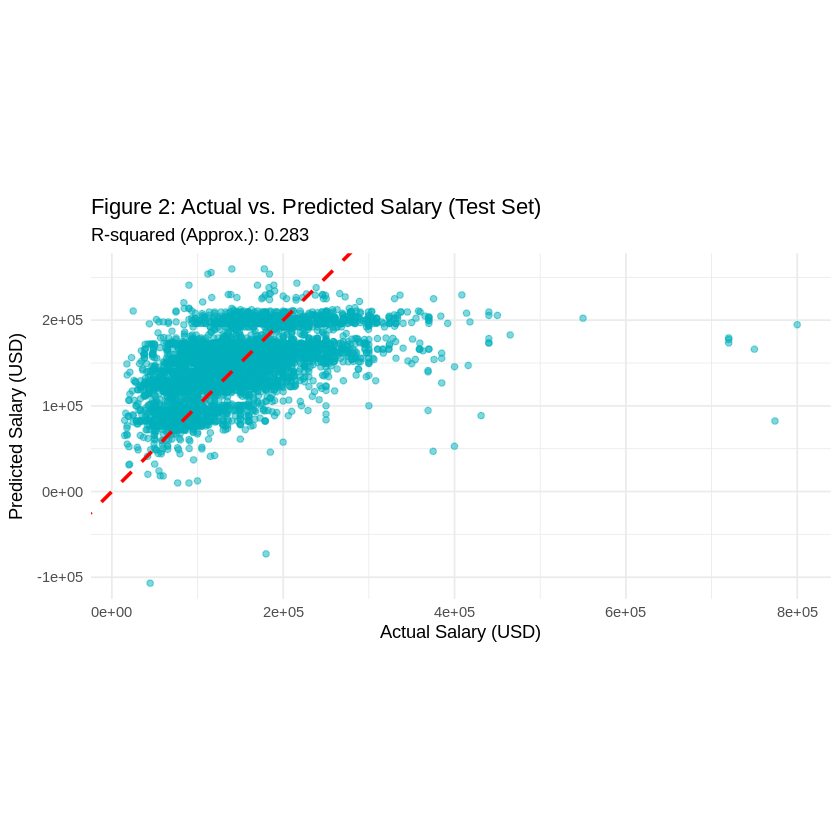

In [26]:

# figure 2
# use trained model to guess salary for 30% test data
test_predictions <- predict(lm_model, newdata = test_data)

# scatter plot to compare the model's guesses (predicted) vs the true salary (actual)
prediction_plot <- ggplot(data.frame(Actual = test_data$Salary, Predicted = test_predictions),
                          aes(x = Actual, y = Predicted)) +
  geom_point(alpha = 0.5, color = "#00AFBB") +
  # dashed prediction line
  geom_abline(intercept = 0, slope = 1, color = "red", linetype = "dashed", linewidth = 1) +
  labs(title = "Figure 2: Actual vs. Predicted Salary (Test Set)",
       x = "Actual Salary (USD)",
       y = "Predicted Salary (USD)",
       subtitle = paste("R-squared (Approx.):", round(summary(lm_model)$r.squared, 3))) +
  theme_minimal() +
  coord_fixed()

print(prediction_plot)

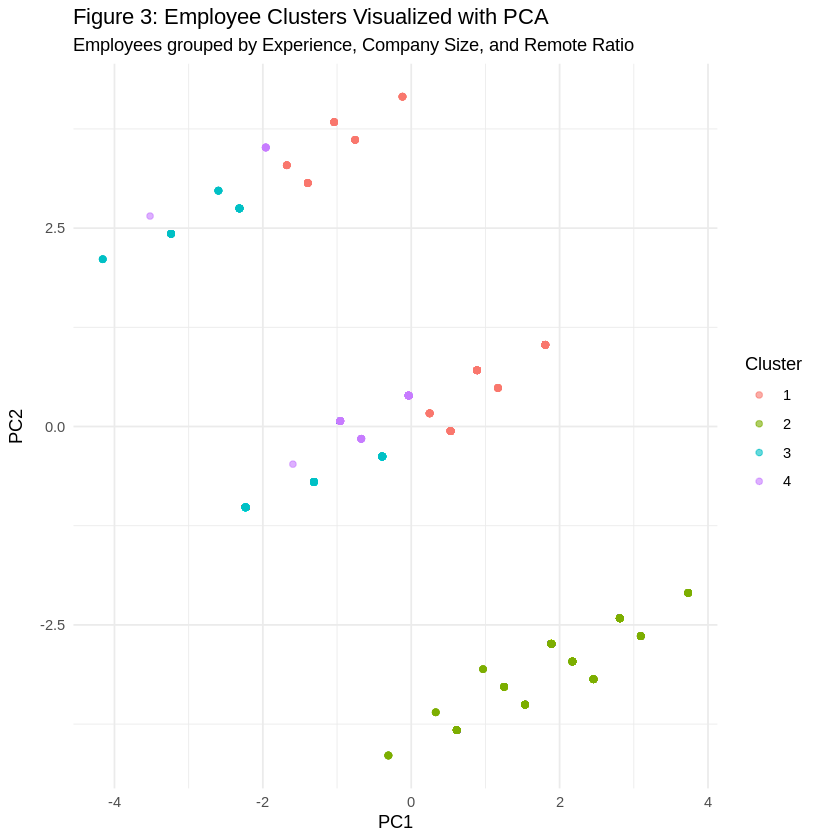

In [30]:
# Method 2

# data prep for k means
# convert ordinal factors to numeric values for clustering
cluster_data <- pre_processed_data %>%
  select(experience.level, company.size, remote.ratio) %>%
  mutate(experience.numeric = as.numeric(experience.level),
         size.numeric = as.numeric(company.size),
         remote.numeric = as.numeric(remote.ratio)) %>%
  select(experience.numeric, size.numeric, remote.numeric)

# scale data
scaled_data <- scale(cluster_data)

# perform k-means
set.seed(42)
k_means_result <- kmeans(scaled_data, centers = 4, nstart = 25)
pre_processed_data$Cluster <- as.factor(k_means_result$cluster)


# figure 3
# PCA to shrink data from 3 dimensions down to 2
pca_result <- prcomp(scaled_data, scale. = TRUE)

# use two main PCA components
pca_plot_data <- data.frame(
  PC1 = pca_result$x[, 1],
  PC2 = pca_result$x[, 2],
  Cluster = pre_processed_data$Cluster
)

# visualize
pca_cluster_plot <- ggplot(pca_plot_data, aes(x = PC1, y = PC2, color = Cluster)) +
  geom_point(alpha = 0.6) +
  labs(title = "Figure 3: Employee Clusters Visualized with PCA",
       subtitle = "Employees grouped by Experience, Company Size, and Remote Ratio") +
  theme_minimal()

print(pca_cluster_plot)

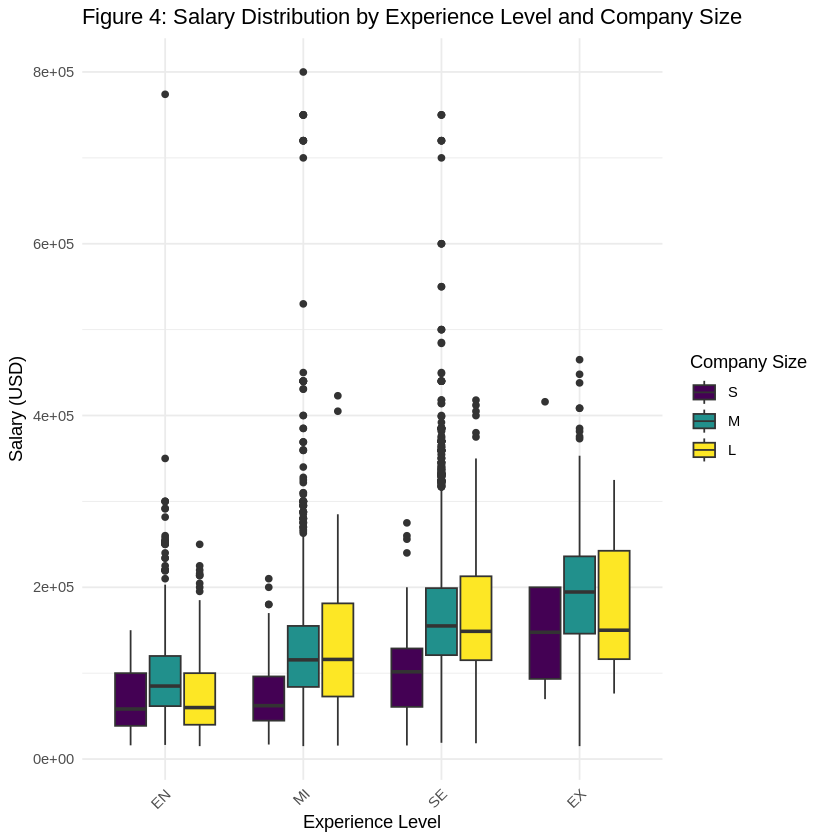

In [31]:
# figure 4
grouped_boxplot <- pre_processed_data %>%
  ggplot(aes(x = experience.level, y = salary.in.usd, fill = company.size)) +
  geom_boxplot() +
  labs(title = "Figure 4: Salary Distribution by Experience Level and Company Size",
       x = "Experience Level",
       y = "Salary (USD)",
       fill = "Company Size") +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))

print(grouped_boxplot)

Warning message:
“Removed 3 rows containing missing values or values outside the scale range
(`geom_line()`).”
Warning message:
“Removed 3 rows containing missing values or values outside the scale range
(`geom_point()`).”


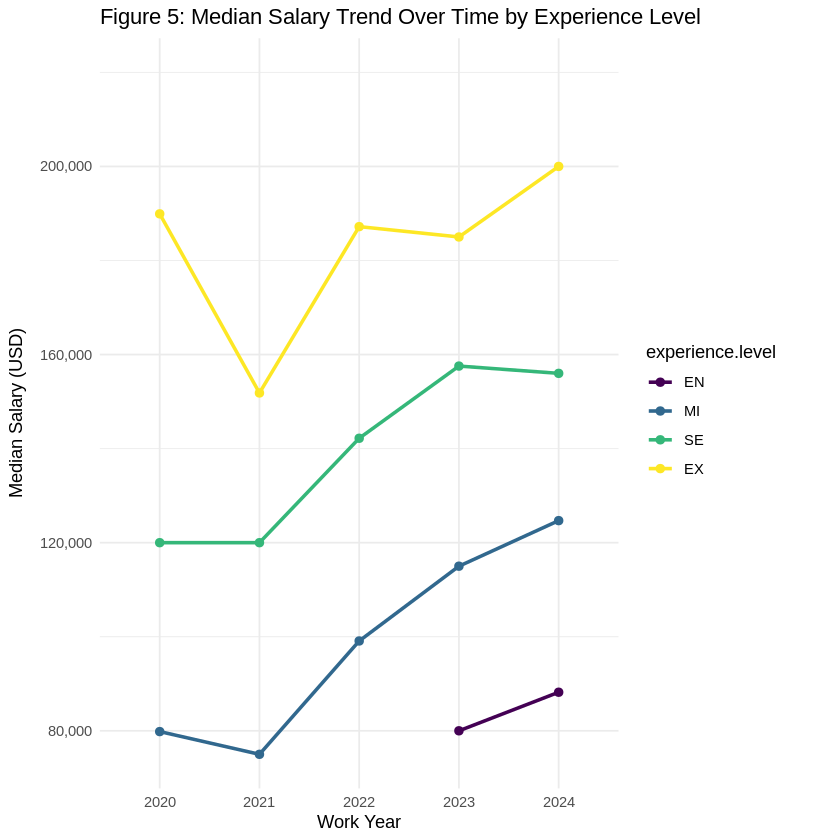

In [32]:
# figure 5
plot_data <- pre_processed_data %>%
  # find median salary for each year and experience level
  group_by(work.year, experience.level) %>%
  summarise(Median.Salary = median(salary.in.usd), .groups = 'drop')

# maximum salary needed for plot
max_median_salary <- max(plot_data$Median.Salary, na.rm = TRUE)

# create plot
yearly_trend_plot <- plot_data %>%
  ggplot(aes(x = as.factor(work.year), y = Median.Salary, color = experience.level, group = experience.level)) +
  geom_line(linewidth = 1) +
  geom_point(size = 2) +

  scale_y_continuous(
    name = "Median Salary (USD)",
    # set axis to start ~$75k and use calculated max_median_salary
    limits = c(75000, max_median_salary * 1.1),
    labels = scales::comma) +  labs(title = "Figure 5: Median Salary Trend Over Time by Experience Level",
       x = "Work Year") +
  theme_minimal()

print(yearly_trend_plot)

**Questions & Answers:**
1. What are the most significant factors driving a data professional's salary and is there evidence of salary growth over the last few years?

    Experience Level and Work Year are the strongest positive predictors, which we see in Figure 1. The median salar for all experience levels has increased substantially from year to year from 2020 to 2024, which demonstrates significant market inflation. The model's predictions show high accuracy, confirming these relationships are robust.

2. Can the job market be meaningfully segmented based on environment (company size, remote ratio) and experience, and how does this affect compensation?

    Yes, the market segments into distinct clusters. The interaction between Experience Level and Company Size is critical: Senior and Executive roles at Large companies command the highest salaries, creating a "premium" segment. Small companies consistently show lower salary distributions, regardless of experience.


**Conclusions**

- The data overwhelmingly shows that the most valuable employee is a Senior/Executive professional working for a Large company (L). Companies must budget significantly more for talent in this segment, as shown by the high coefficients for these features in the regression model in figure 1.

- The most important finding is the strong upward trend in salaries across all years, shown in figure 5. Any salary benchmarking must account for this year-over-year increase, otherwise, retentioin packages or new offers will be dramatically undervalued, leading to higher turnover.

- The clustering analysis successfully shows a simplified view of the job market. This tool lets HR and recruting teams avoid generic salary estimates and instead target compensation strategies for specific employee profiles, such as the "Mid-level Hybrid Employee at a Medium-sized Company."

**What To Do Next**
- *Implement* advanced predictive modeling: You could increase predictive accuracy beyond just the linear methods. You could do this by implementing Random Forest Regression, which is better suited to capture non-linear interactions, such as how the impact of Remote Ratio might depond on the Company Size.

- *Hypothesis* Testing: Use the analysis of variance to statistically test if the mean salary for fully remote employees differs significntly based on their residence compared to the salary of employees at the company location. This would address a highly relevant question regarding compensation fairness in global tech markets.